### Carregamento e Integração dos Dados

Inicialmente, o diretório `/home/jovyan/work` é adicionado ao caminho de busca do Python, viabilizando a importação de módulos utilitários desenvolvidos para o projeto. Em seguida, utiliza-se a classe `DataLoader`, do pacote `utils`, para realizar a leitura dos arquivos CSV referentes às ocorrências de acidentes e às pessoas envolvidas, armazenados em subdiretórios distintos.

Os dados carregados são integrados por meio de uma junção (`join`) baseada na coluna `id`, resultando em um `DataFrame` consolidado (`df_joined`) que reúne informações tanto das ocorrências quanto dos envolvidos, servindo como base para as análises posteriores.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

spark = (
    SparkSession.builder
    .appName("BigData")
    .master("spark://spark-master:7077")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/10 00:15:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os
import sys
sys.path.append("/app")

from utils.dataloader import DataLoader
from utils.workload import Workload

# --- Funções de execução ---
def executar_load(spark, base_dir, schema=None, encoding="utf-8"):
    # CORREÇÃO: Repassar o parâmetro 'encoding' para o construtor do DataLoader
    loader = DataLoader(spark=spark, base_dir=base_dir, schema=schema, encoding=encoding)
    df = loader.load()
    return df

def executar_join(df1=None, df2=None):
    df_joined = DataLoader.join(df1, df2, on=["id"], how="inner")
    return df_joined

# --- Lógica de configuração ---
data_mode = os.environ.get('DATAMODE', 'datasample')

# Define o encoding com base no data_mode
if data_mode == 'full_data':
    source_encoding = 'iso-8859-1'
else:
    source_encoding = 'utf-8'

# Define os caminhos dos dados

base_ocorrencias = f"/app/{data_mode}/ocorrencias"

base_pessoas     = f"/app/{data_mode}/pessoas" 

print(f"✅ Rodando em modo: {data_mode}")
print(f"✅ Usando encoding: {source_encoding}")

# --- Execução das workloads ---

df_ocorrencias = Workload.run(
    title=f"Carregamento dos dados de ocorrências ({data_mode})",
    execute_fn=lambda spark, path, encoding: executar_load(spark, path, encoding=encoding),
    spark=spark,
    path=base_ocorrencias,
    encoding=source_encoding
)

df_pessoas = Workload.run(
    title=f"Carregamento dos dados de pessoas ({data_mode})",
    execute_fn=lambda spark, path, encoding: executar_load(spark, path, encoding=encoding),
    spark=spark,
    path=base_pessoas,
    encoding=source_encoding
)

df_joined = Workload.run(
    title="Junção entre ocorrências e pessoas por ID",
    execute_fn=executar_join,
    df1=df_ocorrencias,
    df2=df_pessoas
)

✅ Rodando em modo: full_data
✅ Usando encoding: iso-8859-1
[WORKLOAD] Carregamento dos dados de ocorrências (full_data)
iso-8859-1


[METRIC] Carregamento dos dados de ocorrências (full_data) executada em 3.699 segundos
[WORKLOAD] Carregamento dos dados de pessoas (full_data)
iso-8859-1


[Stage 3:=====================================================>   (14 + 1) / 15]

[METRIC] Carregamento dos dados de pessoas (full_data) executada em 4.172 segundos
[WORKLOAD] Junção entre ocorrências e pessoas por ID
[METRIC] Junção entre ocorrências e pessoas por ID executada em 0.012 segundos


In [3]:
# from utils.cleaner import salvar_csv

# Workload.run(
#     title="Reescrita em UTF-8 das ocorrências completas",
#     execute_fn=salvar_csv,
#     df=df_ocorrencias,
#     output_path="/app/full_data/ocorrencias_trans",
#     amostra=False,
#     sep=";",
#     encoding="UTF-8"
# )

### Distribuição Etária dos Envolvidos em Acidentes de Trânsito

O código tem por objetivo realizar uma análise quantitativa da distribuição de indivíduos envolvidos em acidentes de trânsito, segmentando-os por faixas etárias. Inicialmente, é definida uma função que recebe um `DataFrame` do PySpark e cria uma nova coluna denominada `faixa_etaria`, a partir da classificação da variável `idade` em intervalos predefinidos: menores de 18 anos (`<18`), de 18 a 29 anos (`18–29`), de 30 a 44 anos (`30–44`), de 45 a 59 anos (`45–59`) e 60 anos ou mais (`60+`).

A seguir, o conjunto de dados é agregado com base nessas faixas etárias, contabilizando o número de registros em cada grupo. Os resultados são convertidos para um `DataFrame` do pandas com o intuito de gerar uma visualização gráfica por meio de um gráfico de barras, que apresenta de forma clara a distribuição dos envolvidos por faixa etária. A função é encapsulada em uma `Workload`, permitindo sua integração no fluxo analítico do projeto, favorecendo a modularização, reutilização e padronização das análises executadas.


[WORKLOAD] Analisa o número de envolvidos em acidentes por faixa etária


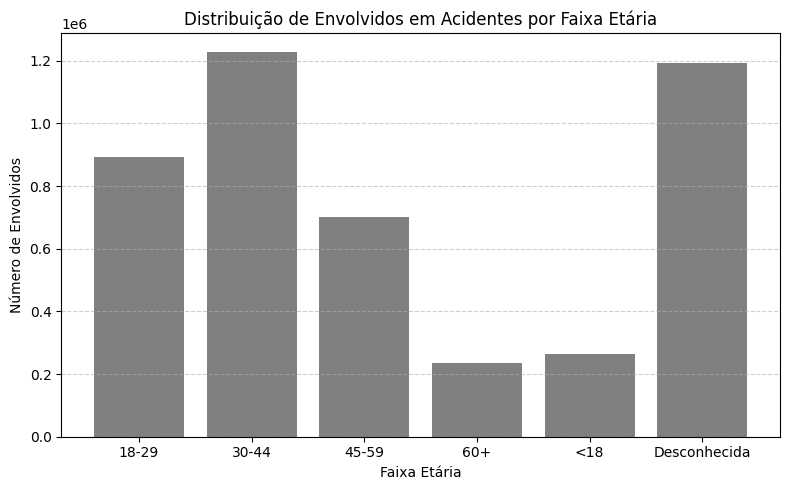

[METRIC] Analisa o número de envolvidos em acidentes por faixa etária executada em 4.836 segundos


In [4]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType # Importe o tipo Integer
import matplotlib.pyplot as plt

def analise_faixa_etaria(df):
    
    # --- ETAPA DE LIMPEZA ---
    # 1. Tenta converter a coluna 'idade' para um número inteiro.
    #    Valores como 'NA' se tornarão NULL.
    df_limpo = df.withColumn(
        "idade_numerica",
        when(col("idade").rlike("^[0-9]+$"), col("idade").cast(IntegerType()))
        .otherwise(None)
    )

    # --- ETAPA DE ANÁLISE (usando a coluna limpa) ---
    # 2. Cria a coluna de faixa etária usando a nova coluna numérica.
    df_faixa_etaria = df_limpo.withColumn(
        "faixa_etaria",
        when(col("idade_numerica") < 18, "<18")
        .when((col("idade_numerica") >= 18) & (col("idade_numerica") < 30), "18-29")
        .when((col("idade_numerica") >= 30) & (col("idade_numerica") < 45), "30-44")
        .when((col("idade_numerica") >= 45) & (col("idade_numerica") < 60), "45-59")
        .when(col("idade_numerica") >= 60, "60+")
        # O otherwise agora pega todos os casos de idade_numerica = NULL (os 'NA' originais)
        .otherwise("Desconhecida")
    )

    # Agrupa por faixa etária
    resultado = df_faixa_etaria.groupBy("faixa_etaria").count().orderBy("faixa_etaria").toPandas()
    
    # Verificação
    # total_grafico = resultado["count"].sum()
    # total_pessoas = df.select("pesid").count() # Usa o df original para contagem total
    # print(f"[VERIFICAÇÃO] Total no gráfico: {total_grafico}")
    # print(f"[VERIFICAÇÃO] Total de pessoas: {total_pessoas}")
     
    # Plot (sem alterações)
    plt.figure(figsize=(8, 5))
    plt.bar(resultado["faixa_etaria"], resultado["count"], color='gray')
    plt.xlabel("Faixa Etária")
    plt.ylabel("Número de Envolvidos")
    plt.title("Distribuição de Envolvidos em Acidentes por Faixa Etária")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Criação e execução da workload
Workload.run(
    title="Analisa o número de envolvidos em acidentes por faixa etária",
    execute_fn=analise_faixa_etaria,
    df=df_pessoas
)

[WORKLOAD] Analisa o número de envolvidos em acidentes por gênero


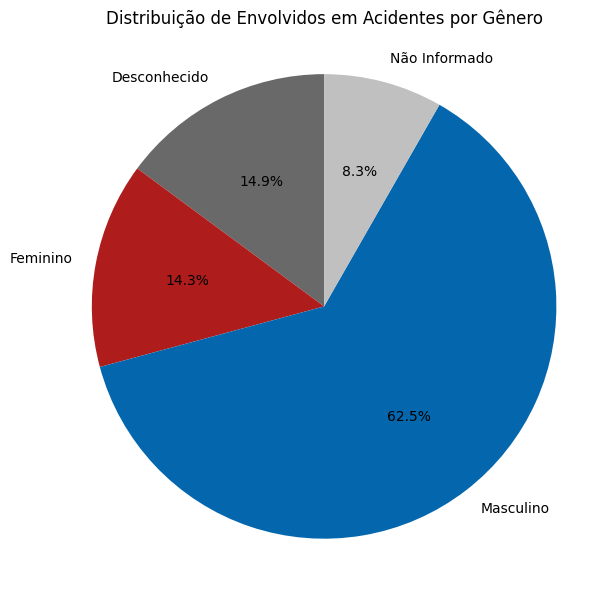

[METRIC] Analisa o número de envolvidos em acidentes por gênero executada em 3.794 segundos


In [5]:
from utils.workload import Workload
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

def analise_distribuicao_genero(df):

    df = df.withColumn(
        "sexo",
        when(col("sexo").isin("Masculino", "M"), "Masculino")
        .when(col("sexo").isin("Feminino", "F"), "Feminino")
        .when(col("sexo").isin("0", "NA", "Não Informado", "Inválido", "", None, "-1"), "Não Informado")
        .otherwise("Desconhecido")
    )

    # Agrupa por sexo
    resultado = df.groupBy("sexo").count().orderBy("sexo").toPandas()

    # Verificação
    # total_grafico = resultado["count"].sum()
    # total_pessoas = df.select("pesid").count()
    # print(f"[VERIFICAÇÃO] Total no gráfico: {total_grafico}")
    # print(f"[VERIFICAÇÃO] Total de pessoas: {total_pessoas}")

    cores_personalizadas = {
        "Masculino": "#0467ae",       # Azul
        "Feminino": "#af1c1c",        # Vermelho
        "Não Informado": "#c0c0c0",   # Cinza claro
        "Desconhecido": "#696969"     # Cinza escuro
    }
    
    # Garante que a ordem dos rótulos siga a ordem correta das cores
    labels_ordenadas = resultado["sexo"].tolist()
    cores_ordenadas = [cores_personalizadas.get(label, "#999999") for label in labels_ordenadas]
    
    plt.figure(figsize=(6, 6))
    plt.pie(
        resultado["count"],
        labels=labels_ordenadas,
        autopct="%1.1f%%",
        startangle=90,
        colors=cores_ordenadas
    )
    plt.title("Distribuição de Envolvidos em Acidentes por Gênero")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

# Criação e execução da workload
Workload.run(
    title="Analisa o número de envolvidos em acidentes por gênero",
    execute_fn=analise_distribuicao_genero,
    df=df_pessoas
)

### Análise Temporal de Acidentes: Distribuição por Hora do Dia

A análise de distribuição de acidentes por hora do dia tem como objetivo identificar a frequência com que os acidentes de trânsito ocorrem ao longo das 24 horas do dia. Esta análise é realizada com base no campo `horario` presente na base de dados consolidada de acidentes, que inclui registros de diversos anos.

Para isso, foi definida uma carga de trabalho (`Workload`) que utiliza PySpark para realizar a transformação dos dados, extraindo a hora de cada ocorrência e agrupando os registros por esse valor. O número de acidentes por hora é então contado e ordenado para facilitar a interpretação.

Após a etapa de processamento, os resultados são convertidos para um DataFrame pandas, permitindo a geração de um gráfico de barras com a biblioteca Matplotlib. Esse gráfico ilustra visualmente como os acidentes se distribuem ao longo do dia, possibilitando a identificação de faixas horárias com maior ou menor incidência de ocorrências.

In [6]:
from pyspark.sql.functions import hour, col, count, year
import matplotlib.pyplot as plt
import pandas as pd

def analise_distribuicao_temporal(df, tipo="hora"):
    """
    Realiza a análise da distribuição temporal de acidentes de trânsito,
    permitindo agrupar os dados por hora do dia, dia da semana ou ano.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados de ocorrências.
    - tipo (str): Tipo de agrupamento temporal. Pode ser 'hora', 'semana' ou 'ano'.
    """

    if tipo == "hora":
        df_temp = df.withColumn("tempo", hour("horario"))
        titulo = "Distribuição Temporal de Acidentes por Hora do Dia"
        eixo_x = "Hora"
    elif tipo == "semana":
        df_temp = df.withColumn("tempo", col("dia_semana"))
        titulo = "Distribuição Temporal de Acidentes por Dia da Semana"
        eixo_x = "Dia da Semana"
    elif tipo == "ano":
        df_temp = df.withColumn("tempo", year(col("data_inversa")))
        titulo = "Distribuição Temporal de Acidentes por Ano"
        eixo_x = "Ano"
    else:
        raise ValueError("O parâmetro 'tipo' deve ser 'hora', 'semana' ou 'ano'.")

    # Agrupa e converte para pandas
    resultado = df_temp.groupBy("tempo").agg(count("*").alias("total")).orderBy("tempo").toPandas()

    # Ordenação dos dias da semana, se necessário
    if tipo == "semana":
        ordem_dias = [
            "segunda-feira", "terça-feira", "quarta-feira",
            "quinta-feira", "sexta-feira", "sábado", "domingo"
        ]
        resultado["tempo"] = pd.Categorical(resultado["tempo"], categories=ordem_dias, ordered=True)
        resultado = resultado.sort_values("tempo")

    # Geração do gráfico
    plt.figure(figsize=(9, 5))
    plt.bar(resultado["tempo"], resultado["total"], color="gray")
    plt.xlabel(eixo_x)
    plt.ylabel("Número de Acidentes")
    plt.title(titulo)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    if tipo == "ano":
        plt.xticks(resultado["tempo"][::1], rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
df_ocorrencias.select("dia_semana").distinct().show()

[Stage 20:=======================>                                  (2 + 2) / 5]

+-------------+
|   dia_semana|
+-------------+
| quarta-feira|
|segunda-feira|
|  sexta-feira|
|      domingo|
|       sábado|
| quinta-feira|
|  terça-feira|
+-------------+



In [8]:
# from utils.cleaner import salvar_csv

# Workload.run(
#     title="Reescrita em UTF-8 das ocorrências completas",
#     execute_fn=salvar_csv,
#     df=df_ocorrencias,
#     output_path="/app/full_data/ocorrenciasss",
#     amostra=False,
#     sep=";",
#     encoding="UTF-8"
# )

[WORKLOAD] Análise Temporal de Acidentes: Distribuição por Hora do Dia


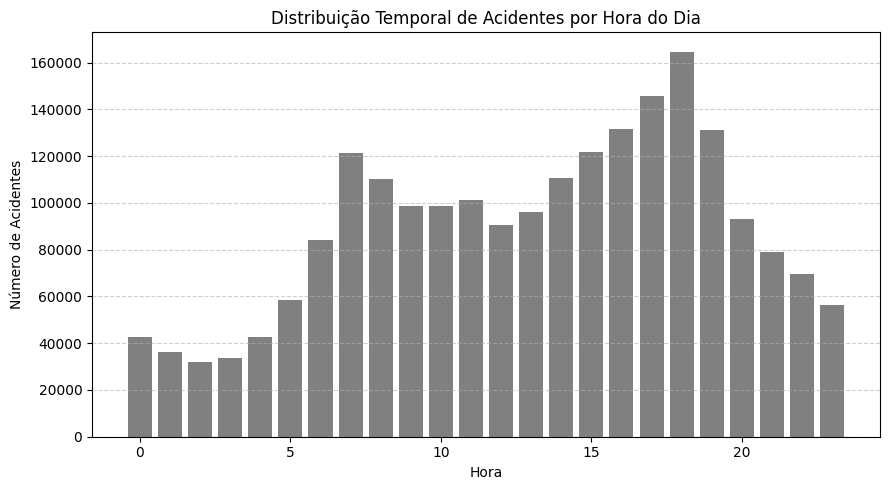

[METRIC] Análise Temporal de Acidentes: Distribuição por Hora do Dia executada em 1.759 segundos


In [9]:
from utils.workload import Workload

# Execução direta da workload para hora do dia
Workload.run(
    title="Análise Temporal de Acidentes: Distribuição por Hora do Dia",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="hora"),
    df=df_ocorrencias
)

[WORKLOAD] Análise Temporal de Acidentes: Distribuição por Dia da Semana


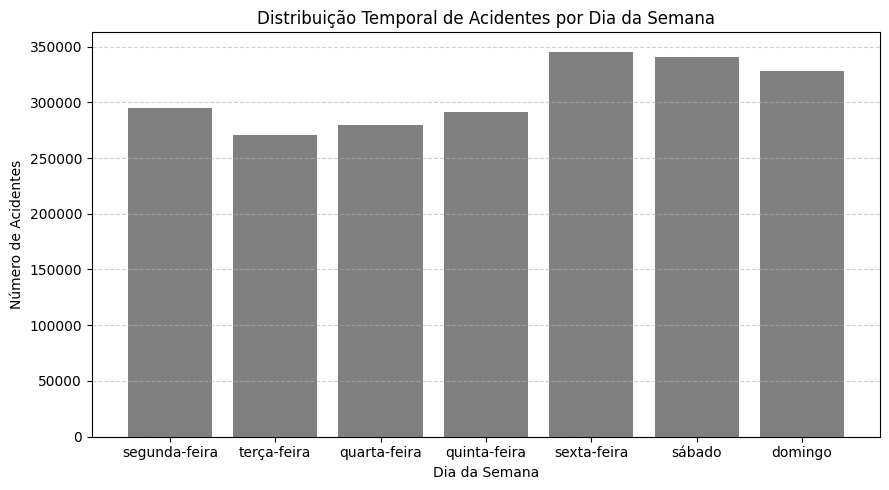

[METRIC] Análise Temporal de Acidentes: Distribuição por Dia da Semana executada em 1.620 segundos


In [10]:
from utils.workload import Workload

# Cria uma workload para distribuição por dia da semana
Workload.run(
    title="Análise Temporal de Acidentes: Distribuição por Dia da Semana",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="semana"),
    df=df_ocorrencias
)

[WORKLOAD] Análise Temporal de Acidentes: Distribuição por Ano


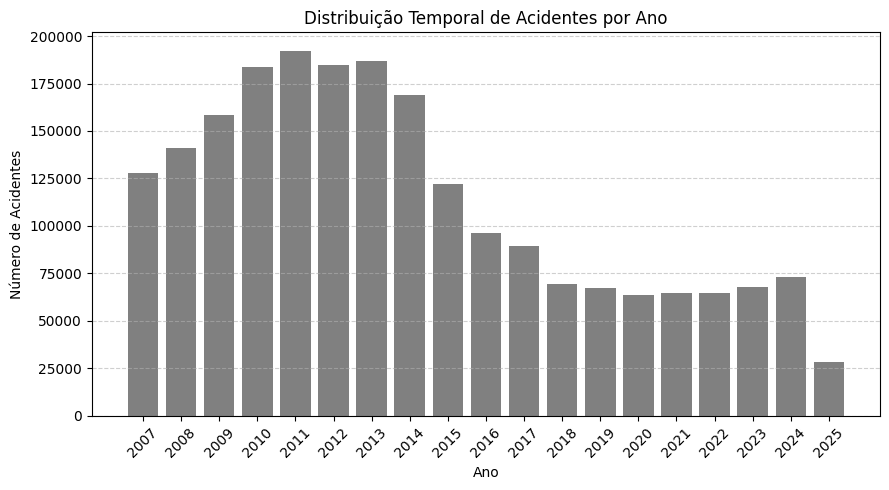

[METRIC] Análise Temporal de Acidentes: Distribuição por Ano executada em 1.557 segundos


In [11]:
from utils.workload import Workload

# Cria uma workload para distribuição por ano
Workload.run(
    title="Análise Temporal de Acidentes: Distribuição por Ano",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="ano"),
    df=df_ocorrencias
)

In [12]:
# --- Relatório final das workloads ---
Workload.print_report()


[WORKLOAD REPORT]
- [WORKLOAD-1] Carregamento dos dados de ocorrências (full_data): 3.699s
- [WORKLOAD-2] Carregamento dos dados de pessoas (full_data): 4.172s
- [WORKLOAD-3] Junção entre ocorrências e pessoas por ID: 0.012s
- [WORKLOAD-4] Analisa o número de envolvidos em acidentes por faixa etária: 4.836s
- [WORKLOAD-5] Analisa o número de envolvidos em acidentes por gênero: 3.794s
- [WORKLOAD-6] Análise Temporal de Acidentes: Distribuição por Hora do Dia: 1.759s
- [WORKLOAD-7] Análise Temporal de Acidentes: Distribuição por Dia da Semana: 1.62s
- [WORKLOAD-8] Análise Temporal de Acidentes: Distribuição por Ano: 1.557s
